# Modelling a planning formula for long distance cycling

In [1]:
%load_ext autotime

time: 284 µs (started: 2021-07-25 20:03:26 -03:00)


In [2]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
import pandas as pd

import statsmodels.api as sm
import pymc3 as pm
import numpy as np
import seaborn as sns

time: 3.85 s (started: 2021-07-25 20:03:26 -03:00)


In [3]:
@dataclass
class Activity():
    label: str
    distance_in_km: float
    uphill_in_m: float
    downhill_in_m: float
    wind_speed_in_kph: float
    moving_time_in_h: float
    avg_hr_in_bpm: float
    consecutive_days: int
    power: float
        
@dataclass
class MesoRegion():
    label: str
    distance_in_km: float
    uphill_in_m: float
    downhill_in_m: float
    avg_wind_speed_in_kph: float
    std_wind_speed_in_kph: float
    
        
activities = [
    Activity('barretos', 430, 4958, 4750, 13, 14 + 26/60, 150, 1, None),
    Activity('cilada', 261, 3308, 3308, 0, 11 + 50/60, 151, 1, None),
    Activity('cananeia', 256, 1567, 2300, 0, 9 + 42/60, 153, 1, 123),
    Activity('pocos_2', 231, 2862, 2890, 0, 9 + 47/60, 145, 2, 116),
    Activity('curitiba_1', 228, 2519, 3250, 0, 9 + 21/60, 153, 1, None),
    Activity('curitiba_2', 212, 2870, 1950, 0, 9 + 27/60, 144, 2, None),
    Activity('campos_jordao', 205, 3310, 3310, 0, 8 + 52/60, 147, 1, None),
    Activity('pocos_3', 203, 2067, 2067, 4, 7 + 52/60, 138, 3, 114),
    Activity('gravel', 200, 2044, 2044, 0, 9 + 12/60, 153, 1, 121),
    Activity('fracassei', 195, 2428, 2600, 9, 8 + 8/60, 144, 1, 116),
    Activity('paraty', 170.2, 1485, 2485, 3, 7+32/60, 144, 2, 115),
    Activity('assou', 158, 1340, 1440, -0.5, 6+35/60, 151, 1, 133),
    Activity('pocos_1', 104, 1656, 1500, 1.0, 4+36/60, 149, 1, 123),
    Activity('...', 144, 1946, 1946, 0, 6+46/60, 152, 1, None),
    Activity('ubatuba_cunha', 113.3, 2469, 1300, -3.5, 6+11/60, 152, 1, 142),
    Activity('3morros', 89.2, 1766, 1766, 0, 4+53/60, 145, 1, 129),
    Activity('taubate_volta', 88.6, 733, 633, 1.5, 2+48/60, 145, 1, 149)
]

meso_regions = [
    MesoRegion('amazon_1', 1025, 3127, 3585, 0.0, 1),
    MesoRegion('amazon_2', 698, 355, 333, 2, 14),
    MesoRegion('rondonia_1', 911, 3197, 2648, 0.5, 2),
    MesoRegion('rondonia_2', 734, 2584, 3021, -1, 14),
    MesoRegion('cerrado_1', 573, 4829, 4377, 1, 14),
    MesoRegion('cerrado_2', 612, 3743, 4112, 1, 14),
    MesoRegion('parana_1', 542, 5016, 4650, 0.5, 1.0),
    MesoRegion('parana_2', 769, 4209, 4813, -.5, 10),
]

df = pd.DataFrame(activities)

df_with_power = df.dropna(subset=['power'])

time: 14.5 ms (started: 2021-07-25 20:03:30 -03:00)


## Bayesian Modelling

In [4]:
def summarize_trace(trace):
    print("-- median --")
    print(trace.posterior.median())
    print("-- std --")
    print(trace.posterior.std())
    print("-- std per median -- ")
    print(trace.posterior.std() / trace.posterior.median())
    pm.plot_trace(trace)
    plt.show()

    bfmi = np.max(pm.stats.bfmi(trace))
    max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.rhat(trace).values()).values
    (
        pm.plot_energy(trace, legend=False, figsize=(6, 4)).set_title(
            f"BFMI = {bfmi :.2e}\nGelman-Rubin = {max_gr :.2e}"
        )
    )
    plt.show()

    pm.plot_posterior(trace)
    plt.show()
    
    pd.plotting.scatter_matrix(trace.posterior.to_dataframe(), figsize=(20, 20))
    plt.show()

time: 479 µs (started: 2021-07-25 20:03:30 -03:00)


### Model 1

$$\hat{t} = \frac{x + \alpha u + \beta d}{v_f + \gamma w}$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_7, w_6, w_5, w_4, w_3, w_2, w_1, w_0, sigma, gamma, v_f, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 40 seconds.


-- median --
<xarray.Dataset>
Dimensions:     ()
Data variables: (12/14)
    beta        float64 -0.005984
    w_0         float64 -0.002307
    w_1         float64 1.993
    w_2         float64 0.499
    w_3         float64 -0.944
    w_4         float64 0.9303
    ...          ...
    w_7         float64 -0.4791
    alpha       float64 0.02027
    v_f         float64 26.88
    gamma       float64 0.5525
    sigma       float64 0.5958
    total_time  float64 232.3
-- std --
<xarray.Dataset>
Dimensions:     ()
Data variables: (12/14)
    beta        float64 0.004378
    w_0         float64 0.3971
    w_1         float64 5.684
    w_2         float64 0.8001
    w_3         float64 5.58
    w_4         float64 5.605
    ...          ...
    w_7         float64 4.035
    alpha       float64 0.004612
    v_f         float64 1.363
    gamma       float64 0.11
    sigma       float64 0.1298
    total_time  float64 10.36
-- std per median -- 
<xarray.Dataset>
Dimensions:     ()
Data variables

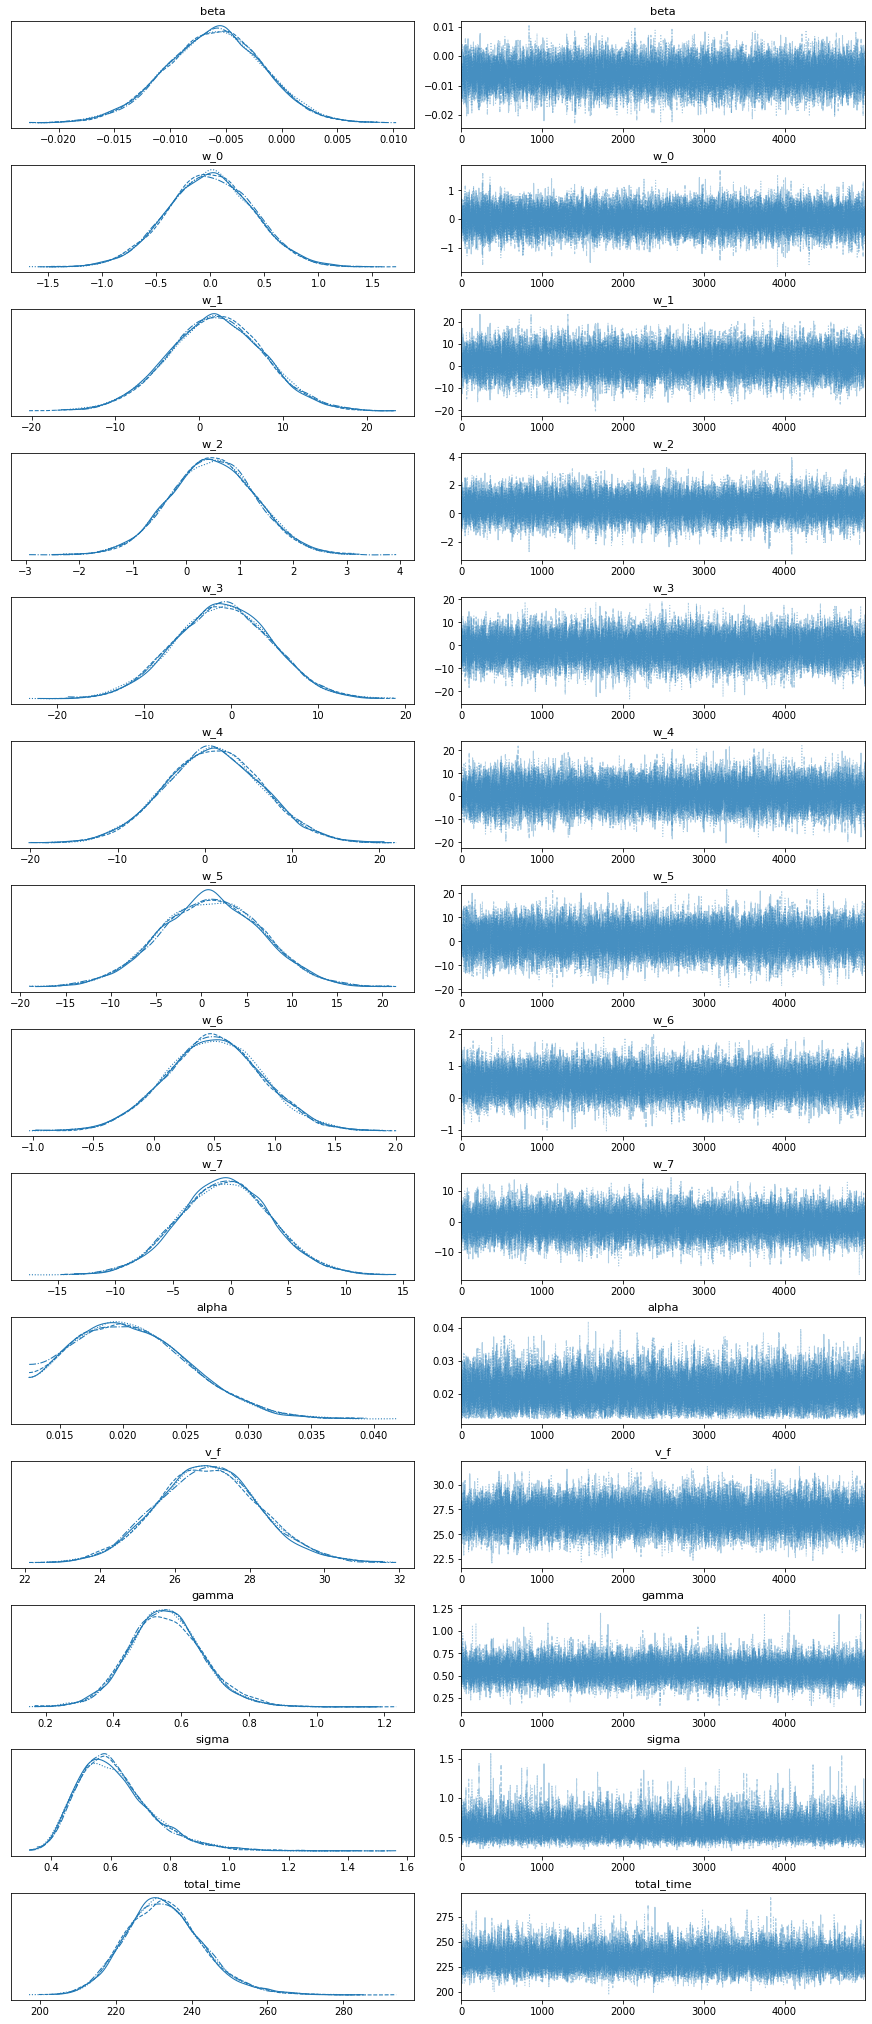

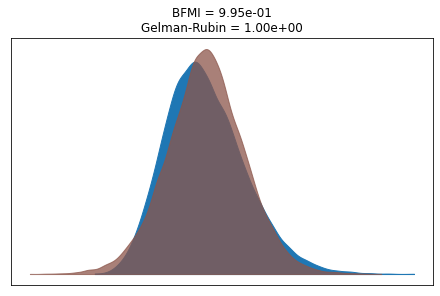

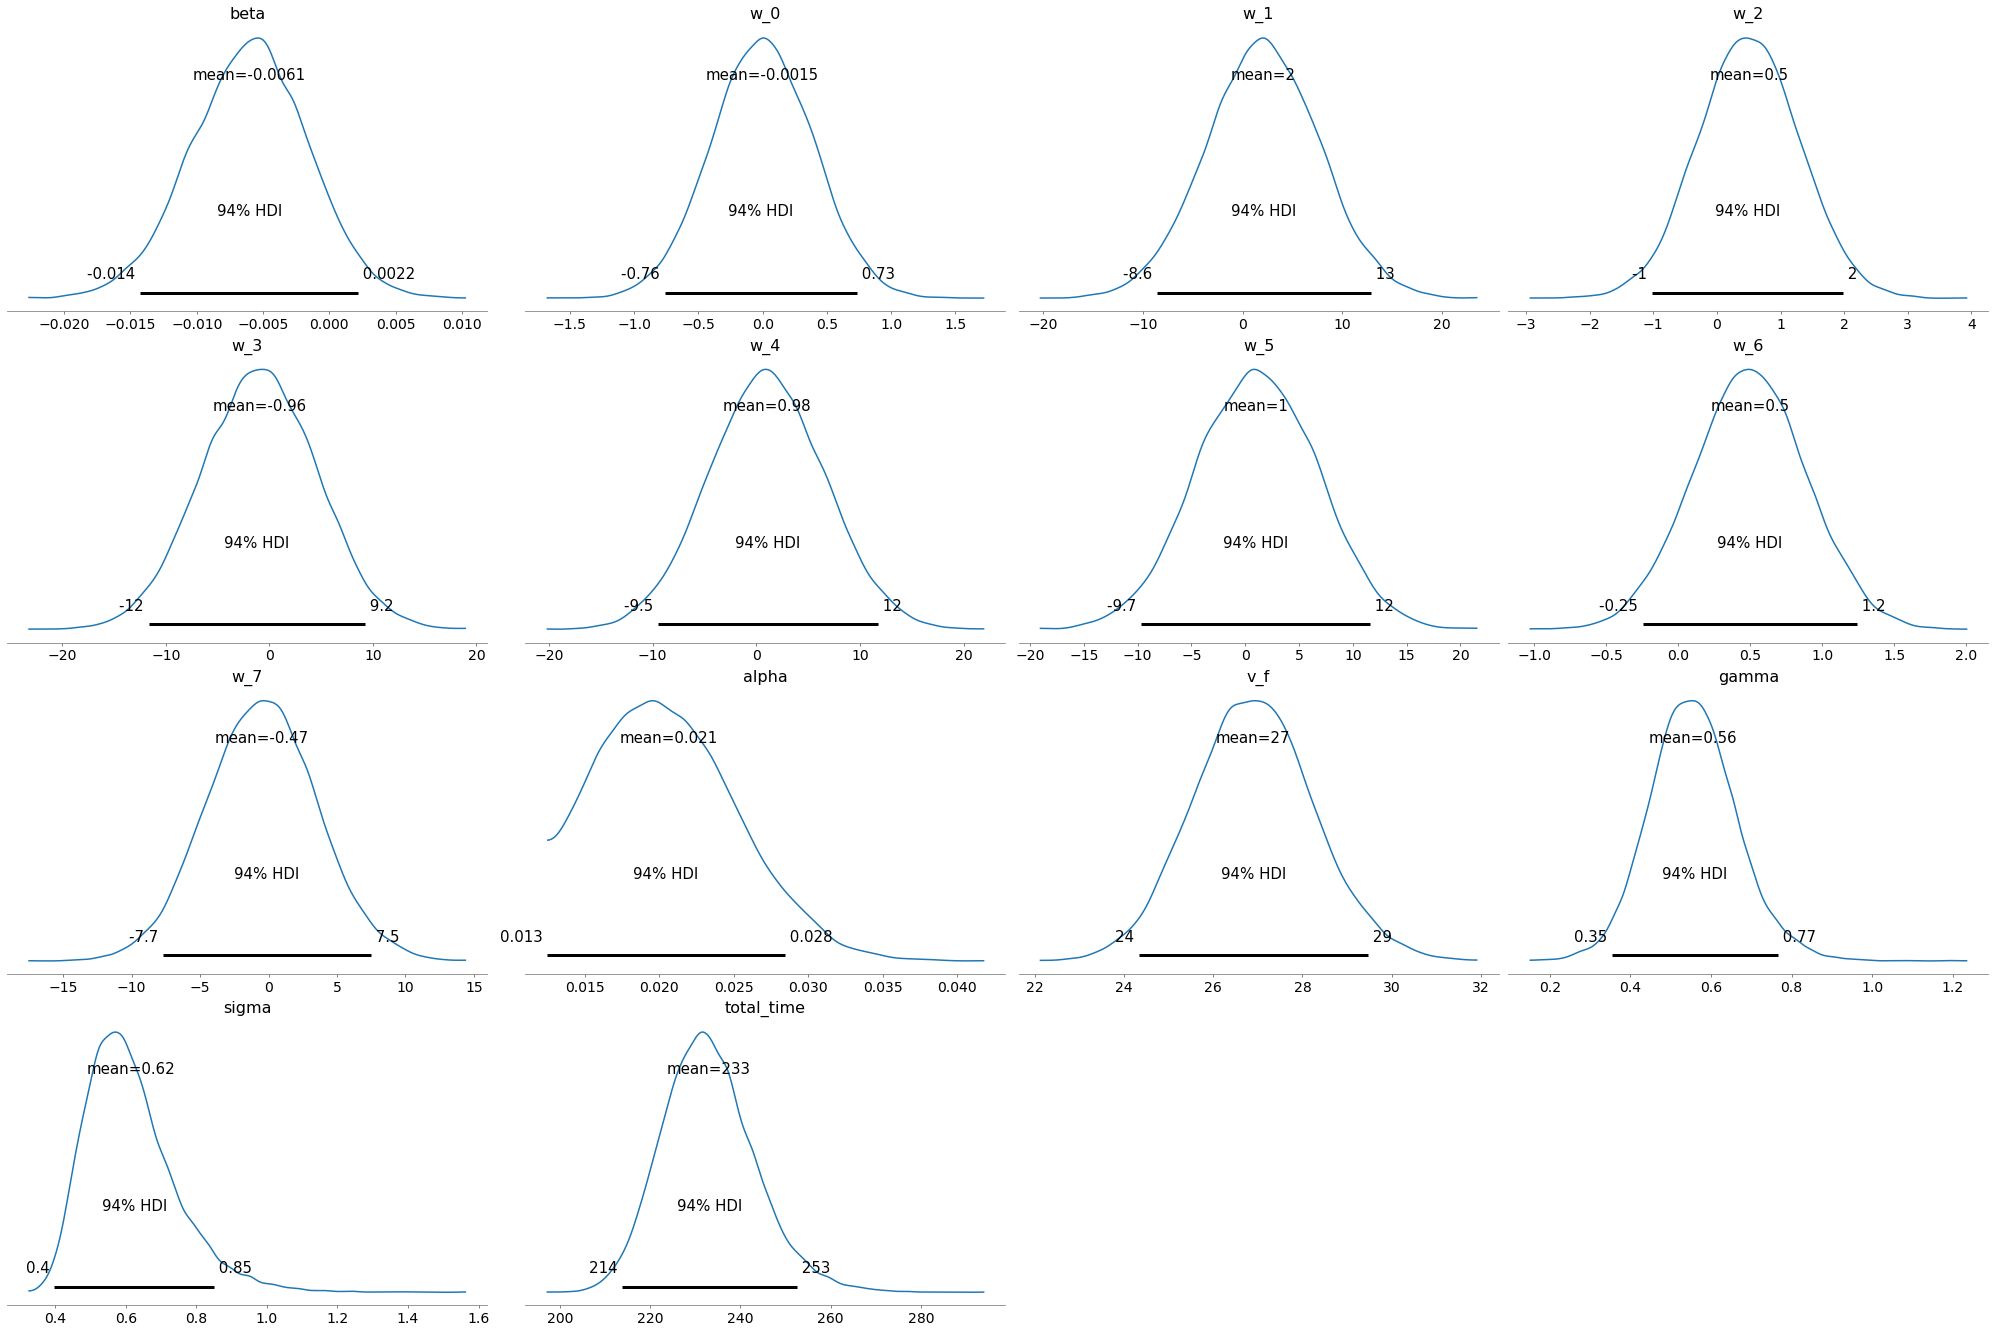

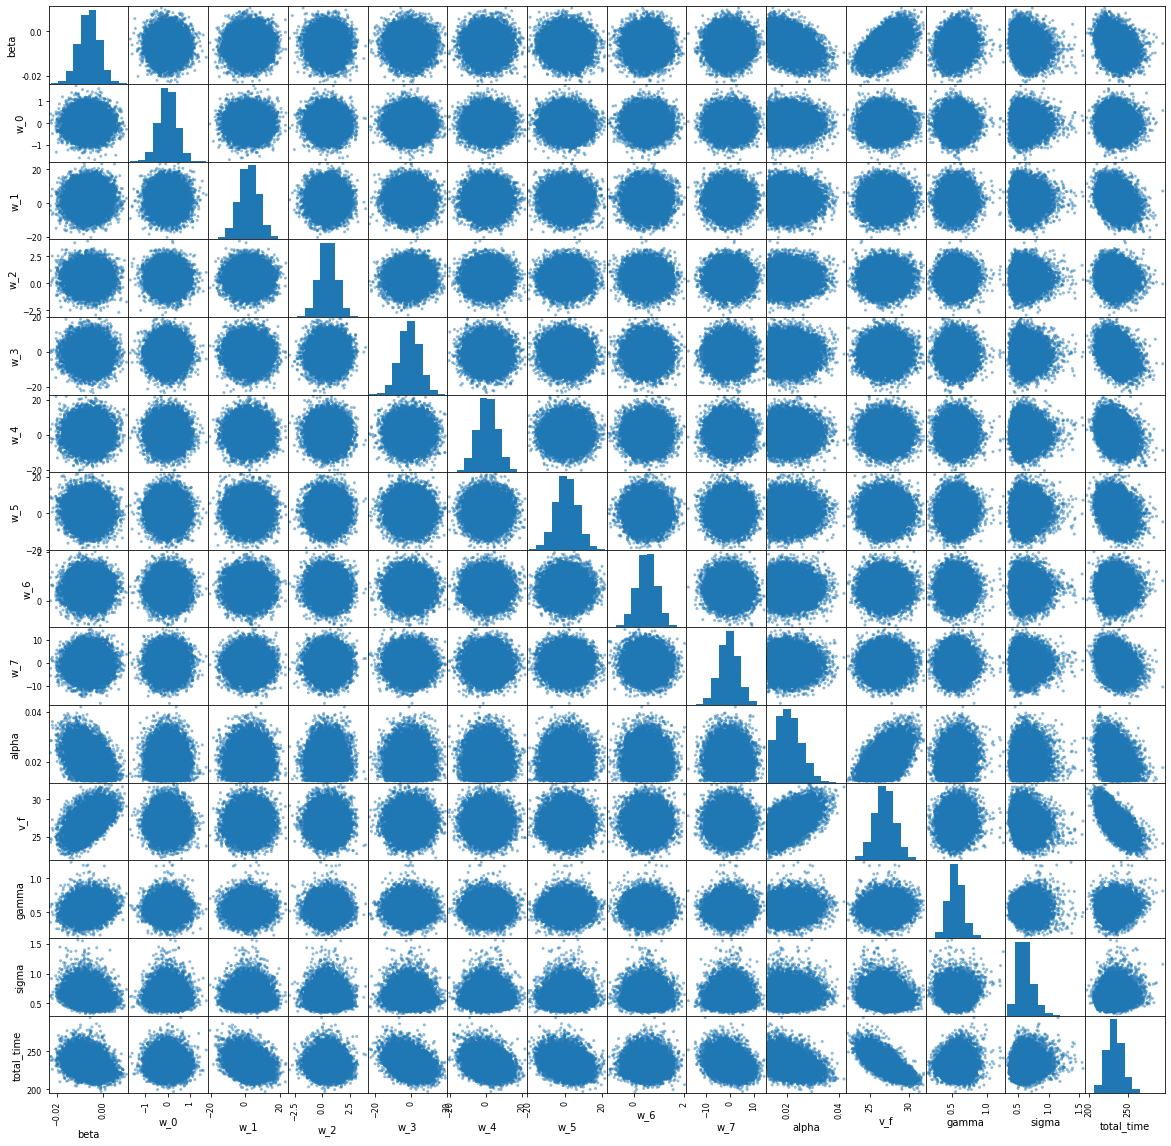

time: 1min 14s (started: 2021-07-25 20:03:44 -03:00)


In [6]:
with pm.Model() as model:
    alpha = pm.TruncatedNormal('alpha', mu=1/50, 
                                        sigma=1/100,
                                        lower=1/80,
                                        upper=1/20)
    beta = pm.Normal('beta', 
                     mu=-1/120, 
                     sigma=1/180)
    
    v_f = pm.TruncatedNormal('v_f', 
                             mu=25.5,
                             sigma=2,
                             lower=20,
                             upper=32)
    
    gamma = pm.TruncatedNormal('gamma', 
                               mu=2/3, 
                               sigma=1/2, 
                               lower=0.0)
    model = (alpha * df.uphill_in_m + beta * df.downhill_in_m)
    model += df.distance_in_km
    model /= (v_f + gamma * df.wind_speed_in_kph)
    
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1)
    
    meso_model = 0.0
    for i, meso_region in enumerate(meso_regions):
        x = meso_region.distance_in_km
        u = meso_region.uphill_in_m
        d = meso_region.downhill_in_m
        w = pm.Normal(f'w_{i}', 
                      mu=meso_region.avg_wind_speed_in_kph,
                      sigma=meso_region.std_wind_speed_in_kph / 2.5) # based on EDA
        meso_model += (x + alpha * u + beta * d) / (v_f + gamma * w)
        
    total_time = pm.Deterministic('total_time', meso_model)
    
    y = df.moving_time_in_h
        
    likelihood = pm.Normal('t', mu=model, sigma=sigma, observed=y)
    
    trace = pm.sample(5_000, 
                      tune=1_000,
                      target_accept=0.95,
                      return_inferencedata=True)
    
summarize_trace(trace)

In [9]:
df = trace.posterior.to_dataframe()

time: 9.29 ms (started: 2021-07-25 20:06:04 -03:00)


<AxesSubplot:>

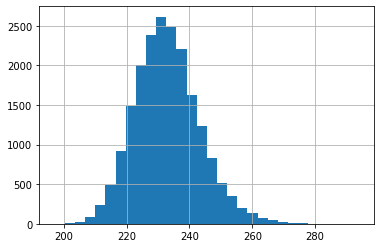

time: 122 ms (started: 2021-07-25 20:06:05 -03:00)


In [10]:
df.total_time.hist(bins=30)

246.23914874900098
232.2688149963214
220.32132323219662


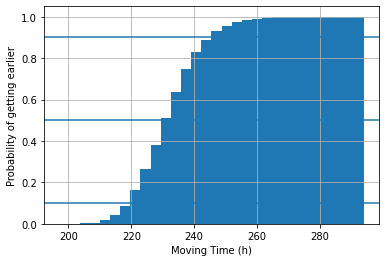

time: 125 ms (started: 2021-07-25 20:06:52 -03:00)


In [14]:
df.total_time.hist(cumulative=True, bins=30, density=1)
plt.axhline(0.5)
plt.axhline(0.9)
plt.axhline(0.1)

print(df.total_time.quantile(0.9))
print(df.total_time.quantile(0.5))
print(df.total_time.quantile(0.1))


plt.ylabel('Probability of getting earlier')
plt.xlabel('Moving Time (h)')
plt.show()

In [ ]:
sns.pairplot(df, kind='hist')